In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch
import os
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [3]:
# Sets the base directory for the dataset
base_dir = '/content/drive/My Drive/datasetL'

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Converts images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation
])

# Datasets
train_dataset = datasets.ImageFolder(os.path.join(base_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(base_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(base_dir, 'test'), transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [4]:
# Loads the pre-trained ResNet
model = models.resnet18(pretrained=True)

# Modifies the final layer to output 5 classes instead of the default 1000
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 5)  # 5 classes for KL grading

# Transfers to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def evaluate(model, data_loader, criterion):
    model.eval()  # Sets the model to evaluation mode
    val_loss = 0.0
    true_labels = []
    predictions = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

    val_loss /= len(data_loader.dataset)
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')
    return val_loss, accuracy, precision, recall, f1


In [6]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=15):
    metrics = {
        'train_loss': [],
        'val_loss': [],  # Stores validation loss for each epoch
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    for epoch in range(num_epochs):
        model.train()  # Sets the model to training mode
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        metrics['train_loss'].append(epoch_loss)

        # Evaluates after every epoch
        val_loss, accuracy, precision, recall, f1 = evaluate(model, val_loader, criterion)
        metrics['val_loss'].append(val_loss)  # Appends validation loss to metrics
        metrics['accuracy'].append(accuracy)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1'].append(f1)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Acc: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

    return metrics


# Calls to train the model
metrics = train_model(model, criterion, optimizer, train_loader, val_loader)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/15
Train Loss: 1.4651, Val Loss: 6.0726, Acc: 0.2519, Precision: 0.2672, Recall: 0.2519, F1: 0.1573


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/15
Train Loss: 1.1131, Val Loss: 2.4814, Acc: 0.4000, Precision: 0.2877, Recall: 0.4000, F1: 0.3249
Epoch 3/15
Train Loss: 0.8747, Val Loss: 1.4140, Acc: 0.5037, Precision: 0.4158, Recall: 0.5037, F1: 0.4382
Epoch 4/15
Train Loss: 0.8321, Val Loss: 1.0873, Acc: 0.5185, Precision: 0.5262, Recall: 0.5185, F1: 0.4999
Epoch 5/15
Train Loss: 0.7216, Val Loss: 2.2607, Acc: 0.4148, Precision: 0.4378, Recall: 0.4148, F1: 0.3180
Epoch 6/15
Train Loss: 0.6860, Val Loss: 1.2422, Acc: 0.5481, Precision: 0.4474, Recall: 0.5481, F1: 0.4880
Epoch 7/15
Train Loss: 0.4919, Val Loss: 1.7611, Acc: 0.4222, Precision: 0.4333, Recall: 0.4222, F1: 0.3873
Epoch 8/15
Train Loss: 0.5560, Val Loss: 1.6348, Acc: 0.4667, Precision: 0.5008, Recall: 0.4667, F1: 0.4510
Epoch 9/15
Train Loss: 0.4573, Val Loss: 2.1724, Acc: 0.4296, Precision: 0.4366, Recall: 0.4296, F1: 0.3782
Epoch 10/15
Train Loss: 0.3202, Val Loss: 2.4321, Acc: 0.4296, Precision: 0.4917, Recall: 0.4296, F1: 0.4189
Epoch 11/15
Train Loss: 0.2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/15
Train Loss: 0.2112, Val Loss: 2.3609, Acc: 0.4963, Precision: 0.4281, Recall: 0.4963, F1: 0.4320
Epoch 15/15
Train Loss: 0.2612, Val Loss: 1.7984, Acc: 0.5185, Precision: 0.5666, Recall: 0.5185, F1: 0.4931


In [7]:
# Evaluates on the test set
test_val_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_val_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}')


Test Loss: 2.2632, Test Accuracy: 0.4875, Precision: 0.5439, Recall: 0.4875, F1 Score: 0.4566


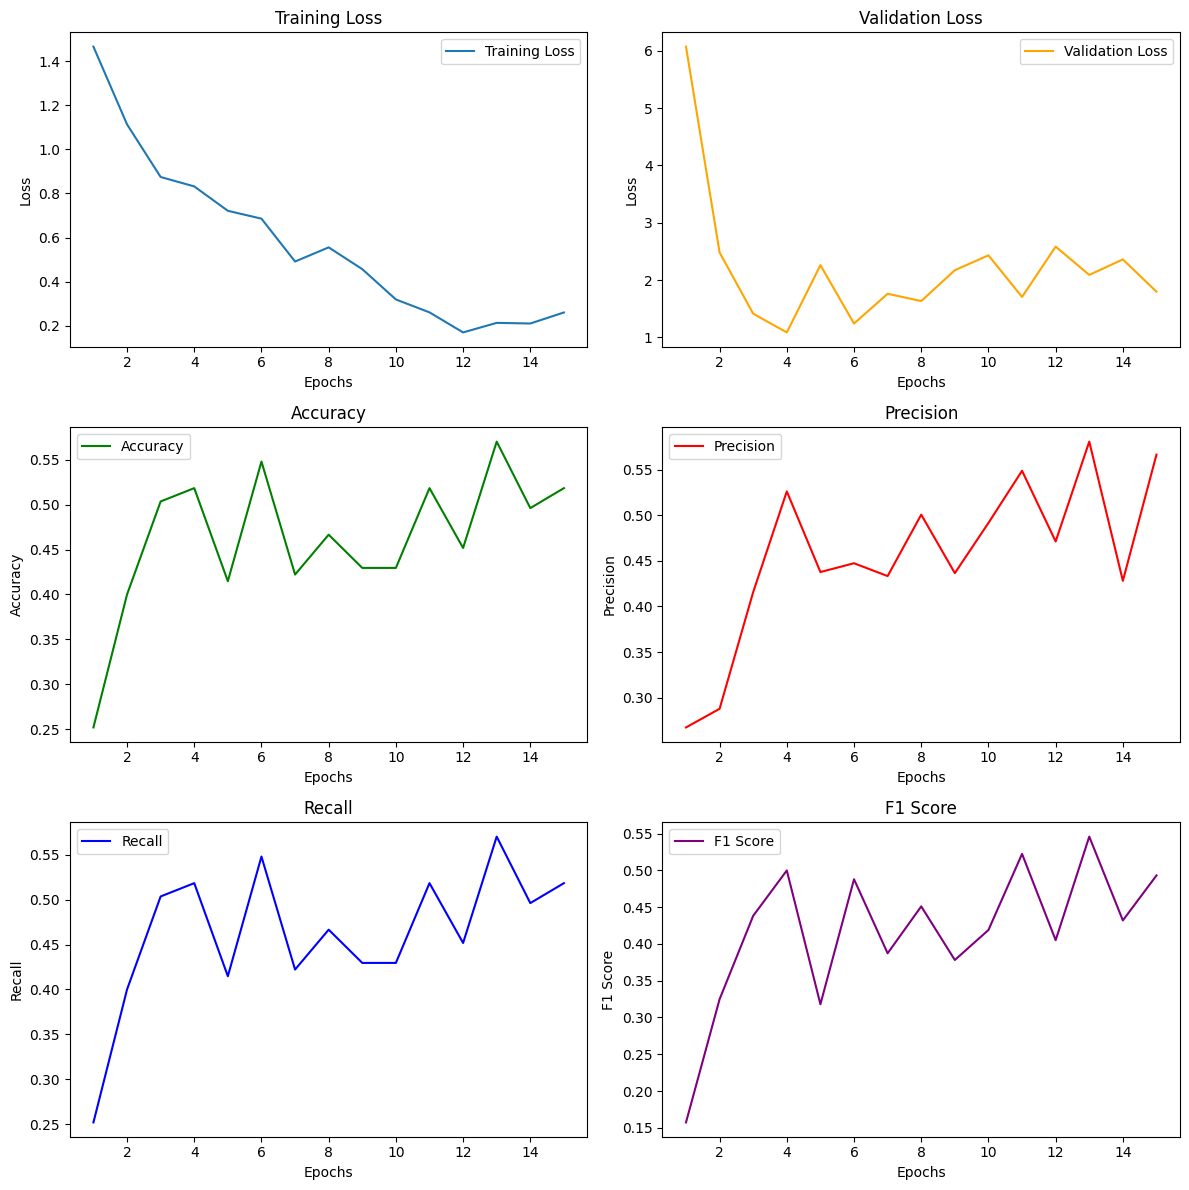

In [8]:
import matplotlib.pyplot as plt

def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    plt.figure(figsize=(12, 12))

    plt.subplot(3, 2, 1)
    plt.plot(epochs, metrics['train_loss'], label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(3, 2, 2)
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss', color='orange')
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(3, 2, 3)
    plt.plot(epochs, metrics['accuracy'], label='Accuracy', color='g')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(3, 2, 4)
    plt.plot(epochs, metrics['precision'], label='Precision', color='r')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(3, 2, 5)
    plt.plot(epochs, metrics['recall'], label='Recall', color='b')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.subplot(3, 2, 6)
    plt.plot(epochs, metrics['f1'], label='F1 Score', color='purple')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(metrics)

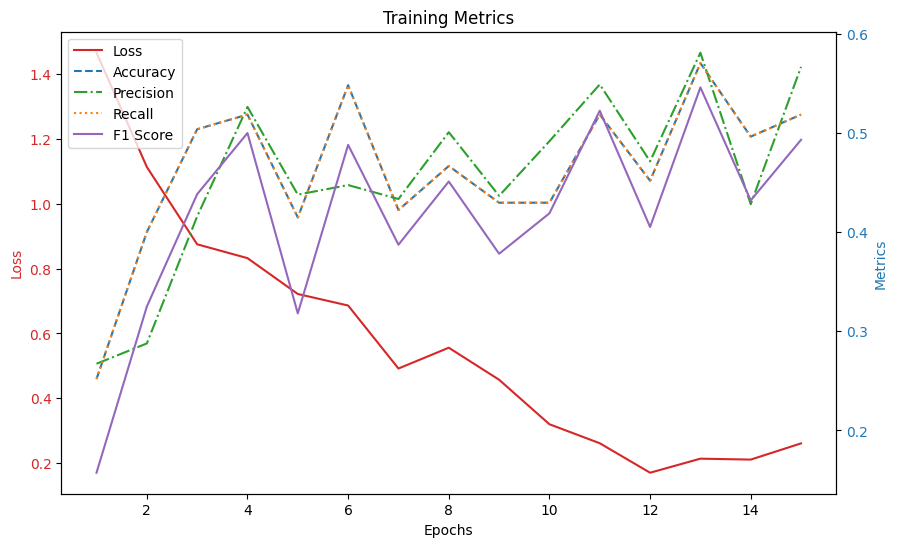

In [9]:
def plot_combined_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plots training loss on the first y-axis
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, metrics['train_loss'], label='Loss', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Creates a second y-axis for the accuracy, precision, recall, and F1
    ax2 = ax1.twinx()
    ax2.set_ylabel('Metrics', color='tab:blue')
    ax2.plot(epochs, metrics['accuracy'], label='Accuracy', color='tab:blue', linestyle='--')
    ax2.plot(epochs, metrics['precision'], label='Precision', color='tab:green', linestyle='-.')
    ax2.plot(epochs, metrics['recall'], label='Recall', color='tab:orange', linestyle=':')
    ax2.plot(epochs, metrics['f1'], label='F1 Score', color='tab:purple', linestyle='-')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Creates a legend that includes all the lines
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.title('Training Metrics')
    plt.show()

# Call the plotting function
plot_combined_metrics(metrics)